In [1]:
import sys
# Use cloned repo not pip - will make changes to the library
sys.path[0] = 'd:\\DesktopHDD\\PhD Courses\\ECCE 794\\RL\\Project\\mobile-env'

In [2]:
import gymnasium
import matplotlib.pyplot as plt
# importing mobile_env automatically registers the predefined scenarios in Gym
import mobile_env
from IPython import display

# create a small mobile environment for a single, centralized control agent
# pass rgb_array as render mode so the env can be rendered inside the notebook
env = gymnasium.make("mobile-small-central-v0", render_mode="rgb_array")

print(f"\nSmall environment with {env.NUM_USERS} users and {env.NUM_STATIONS} cells.")


Small environment with 5 users and 3 cells.


In [3]:
# predefined small scenarios
from mobile_env.scenarios.small import MComSmall

# easy access to the default configuration
MComSmall.default_config()

{'width': 200,
 'height': 200,
 'EP_MAX_TIME': 100,
 'seed': 0,
 'reset_rng_episode': False,
 'arrival': mobile_env.core.arrival.NoDeparture,
 'channel': mobile_env.core.channels.OkumuraHata,
 'scheduler': mobile_env.core.schedules.ResourceFair,
 'movement': mobile_env.core.movement.RandomWaypointMovement,
 'utility': mobile_env.core.utilities.BoundedLogUtility,
 'handler': mobile_env.handlers.central.MComCentralHandler,
 'bs': {'bw': 9000000.0, 'freq': 2500, 'tx': 30, 'height': 50},
 'ue': {'velocity': 1.5, 'snr_tr': 2e-08, 'noise': 1e-09, 'height': 1.5},
 'arrival_params': {'ep_time': 100, 'reset_rng_episode': False},
 'channel_params': {},
 'scheduler_params': {},
 'movement_params': {'width': 200, 'height': 200, 'reset_rng_episode': False},
 'utility_params': {'lower': -20, 'upper': 20, 'coeffs': (10, 0, 10)},
 'metrics': {'scalar_metrics': {}, 'ue_metrics': {}, 'bs_metrics': {}}}

D:\Lib\site-packages\gymnasium\utils\passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


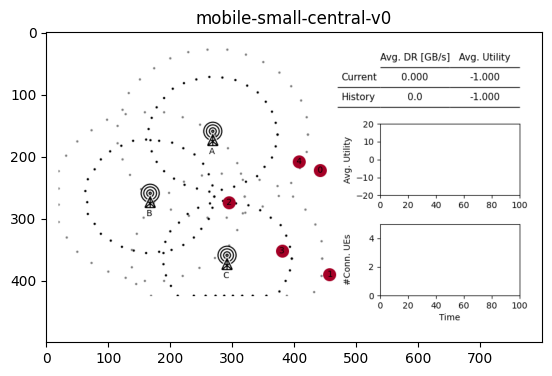

In [4]:
def plot_env(env_name):
    """Create env, take a random step, and then render the environment."""
    env = gymnasium.make(env_name, render_mode="rgb_array")
    env.reset()
    env.step(env.action_space.sample())
    plt.imshow(env.render())
    plt.title(env_name)

# plot small env from earlier
plot_env("mobile-small-central-v0")

### Custom Scenario

It is also easy to define a custom scenario by subclassing `mobile-env`'s `MComCore` base class.

Here, we create a custom scenario with two cells and three users, where one user is stationary and the other two users move quickly with 10 m/s.

We also configure the environment to simulate each episode with identical user positions and movement. By default, users appear and move randomly in each episode.
We also set the episode length to 10 (instead of default 100 steps).

In [ ]:
from mobile_env.core.base import MComCore
from mobile_env.core.entities import BaseStation, UserEquipment


class CustomEnv(MComCore):
    # overwrite the default config
    @classmethod
    def default_config(cls):
        config = super().default_config()
        config.update({
            # 10 steps per episode
            "EP_MAX_TIME": 10,
            # identical episodes
            "seed": 1234,
            'reset_rng_episode': True,
        })
        # faster user movement
        config["ue"].update({
            "velocity": 10,
        })
        return config

    # configure users and cells in the constructor
    def __init__(self, config={}, render_mode=None):
        # load default config defined above; overwrite with custom params
        env_config = self.default_config()
        env_config.update(config)

        # two cells next to each other; unpack config defaults for other params
        stations = [
            BaseStation(bs_id=0, pos=(50, 100), **env_config["bs"]),
            BaseStation(bs_id=1, pos=(100, 100), **env_config["bs"])
        ]

        # users
        users = [
            # two fast moving users with config defaults
            UserEquipment(ue_id=1, **env_config["ue"]),
            UserEquipment(ue_id=2, **env_config["ue"]),
            # stationary user --> set velocity to 0
            UserEquipment(ue_id=3, velocity=0, snr_tr=env_config["ue"]["snr_tr"], noise=env_config["ue"]["noise"],
                          height=env_config["ue"]["height"]),
        ]

        super().__init__(stations, users, config, render_mode)


# init and render the custom scenario
env = CustomEnv(render_mode="rgb_array")
env.reset()
for _ in range(10):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(dummy_action)

    # render the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [5]:
#env = CustomEnv(config={"seed": 42})
#obs, info = env.reset(seed=42)
env = gymnasium.make("mobile-small-central-v0", render_mode="rgb_array")
env.reset()
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

print("Raw observations: ", obs)

# connections and SNR are per user and station, utility just per user
obs_per_user = 2 * env.NUM_STATIONS + 1
for ue in range(env.NUM_USERS):
    print(f"\nObservations for user {ue + 1}:")
    offset = ue * obs_per_user
    print(f"Current connections to the {env.NUM_STATIONS} cells: {obs[offset:offset+env.NUM_STATIONS]}")
    print(f"SNR to the {env.NUM_STATIONS} cells: {obs[offset+env.NUM_STATIONS:offset+2*env.NUM_STATIONS]}")
    print(f"Current utility: {obs[offset+2*env.NUM_STATIONS]}")


Raw observations:  [ 0.          0.          0.          1.          0.2516919   0.56135505
 -1.          0.          0.          0.          0.11989262  0.1122832
  1.         -1.          0.          0.          0.          0.4710008
  0.44577658  1.         -1.          0.          0.          0.
  0.03805785  0.04028227  1.         -1.          0.          0.
  0.          1.          0.17299446  0.3024028  -1.        ]

Observations for user 1:
Current connections to the 3 cells: [0. 0. 0.]
SNR to the 3 cells: [1.         0.2516919  0.56135505]
Current utility: -1.0

Observations for user 2:
Current connections to the 3 cells: [0. 0. 0.]
SNR to the 3 cells: [0.11989262 0.1122832  1.        ]
Current utility: -1.0

Observations for user 3:
Current connections to the 3 cells: [0. 0. 0.]
SNR to the 3 cells: [0.4710008  0.44577658 1.        ]
Current utility: -1.0

Observations for user 4:
Current connections to the 3 cells: [0. 0. 0.]
SNR to the 3 cells: [0.03805785 0.04028227 1.    

In [ ]:
# # from mobile_env.handlers.central import MComCentralHandler
# # import numpy as np


# # class CustomHandler(MComCentralHandler):
# #     # let's call the new observation "any_connection"
# #     features = MComCentralHandler.features + ["any_connection"]

# #     # overwrite the observation size per user
# #     @classmethod
# #     def ue_obs_size(cls, env) -> int:
# #         """Increase observations by 1 for each user for the new obs"""
# #         # previously: connections for all cells, SNR for all cells, utility
# #         prev_size = env.NUM_STATIONS + env.NUM_STATIONS + 1
# #         return prev_size + 1

# #     # add the new observation
# #     @classmethod
# #     def observation(cls, env) -> np.ndarray:
# #         """Concatenated observations for all users"""
# #         # get all available obs from the env
# #         obs_dict = env.features()

# #         # add the new observation for each user (ue)
# #         for ue_id in obs_dict.keys():
# #             any_connection = np.any(obs_dict[ue_id]["connections"])
# #             obs_dict[ue_id]["any_connection"] = int(any_connection)

# #         # select the relevant obs and flatten into single vector
# #         flattened_obs = []
# #         for ue_id, ue_obs in obs_dict.items():
# #             flattened_obs.extend(ue_obs["connections"])
# #             flattened_obs.append(ue_obs["any_connection"])
# #             flattened_obs.extend(ue_obs["snrs"])
# #             flattened_obs.extend(ue_obs["utility"])

# #         return flattened_obs
# # create the env with the new handler and check the obs
# env = CustomEnv(config={"handler": CustomHandler})
# obs, info = env.reset()
# obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

# print("New, raw observations: ", obs)

# # connections and SNR are per user and station, utility just per user
# obs_per_user = 2 * env.NUM_STATIONS + 2
# for ue in range(env.NUM_USERS):
#     print(f"\nObservations for user {ue + 1}:")
#     offset = ue * obs_per_user
#     print(f"Current connections to the {env.NUM_STATIONS} cells: {obs[offset:offset+env.NUM_STATIONS]}")
#     print(f"NEW: Any connection?: {obs[offset+env.NUM_STATIONS]}")
#     print(f"SNR to the {env.NUM_STATIONS} cells: {obs[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1]}")
#     print(f"Current utility: {obs[offset+2*env.NUM_STATIONS+1]}")

In [7]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

# train PPO agent on environment. this takes a while
model = PPO(MlpPolicy, env, tensorboard_log='results_sb', verbose=1)
model.learn(total_timesteps=500000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to results_sb\PPO_12
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -38.2    |
| time/              |          |
|    fps             | 133      |
|    iterations      | 1        |
|    time_elapsed    | 15       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -38.1       |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 2           |
|    time_elapsed         | 31          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013445304 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2  

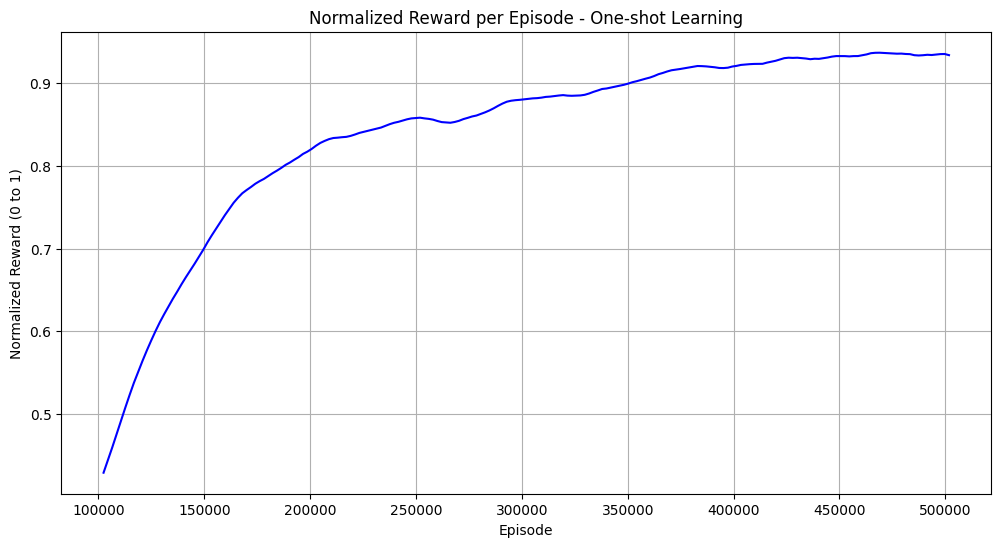

In [22]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import pandas as pd
# Path to your TensorBoard log files
log_dir = 'results_sb/PPO_12'

# Initialize the event accumulator
ea = event_accumulator.EventAccumulator(log_dir,
    size_guidance={event_accumulator.SCALARS: 0})  # 0 means load all scalars

# Load the data
ea.Reload()
# Assuming 'reward' is the tag for your scalar metric. Replace 'reward' with the actual tag name.
# This tag name depends on how you have logged the data in your TensorFlow/TensorBoard script.
if 'rollout/ep_rew_mean' in ea.Tags()['scalars']:
    rewards = [scalar.value for scalar in ea.Scalars('rollout/ep_rew_mean')]
    steps = [scalar.step for scalar in ea.Scalars('rollout/ep_rew_mean')]  # Or use scalar.wall_time for timestamps

    # Optionally, convert rewards and steps to a numpy array for further processing
    rewards_array = np.array(rewards)
    steps_array = np.array(steps)

    # Now, you can work with rewards_array and steps_array as needed
else:
    print("Reward tag not found in TensorBoard logs.")


# Min-Max Normalization to scale rewards between -1 and 1
min_reward = np.min(rewards_array)
max_reward = np.max(rewards_array)
normalized_rewards =  ((rewards_array - min_reward) / (max_reward - min_reward))

# Apply a moving average to smooth the data with a window size
window_size = 50  # The window size can be adjusted based on the dataset
smoothed_rewards = pd.Series(normalized_rewards).rolling(window=window_size).mean()

# Plotting the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(steps_array, smoothed_rewards, linestyle='-', color='b')
plt.title('Normalized Reward per Episode - One-shot Learning')
plt.xlabel('Episode')
plt.ylabel('Normalized Reward (0 to 1)')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

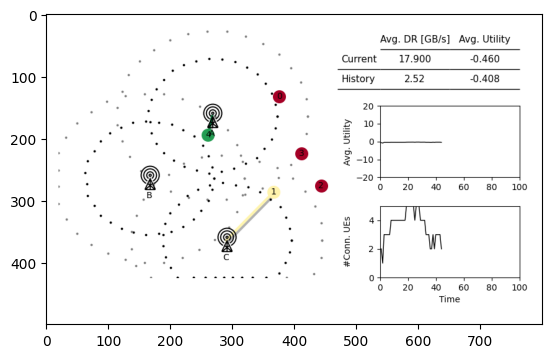

In [23]:
env = gymnasium.make("mobile-small-central-v0", render_mode="rgb_array")
obs, info = env.reset()
done = False

# run one episode with the trained model
while not done:
    action, _ = model.predict(obs)

    # perform step on simulation environment
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # render environment as RGB
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [24]:
model.save("one_shot_500000steps")